# 02a training a quantum model on a real dataset

In [1]:
# This code is from the tutorial at:
# https://qiskit-community.github.io/qiskit-machine-learning/tutorials/02a_training_a_quantum_model_on_a_real_dataset.html

In [2]:
from sklearn.datasets import load_iris

iris_data = load_iris()

In [3]:
print(iris_data.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

:Number of Instances: 150 (50 in each of three classes)
:Number of Attributes: 4 numeric, predictive attributes and the class
:Attribute Information:
    - sepal length in cm
    - sepal width in cm
    - petal length in cm
    - petal width in cm
    - class:
            - Iris-Setosa
            - Iris-Versicolour
            - Iris-Virginica

:Summary Statistics:

============== ==== ==== ======= ===== ====================
                Min  Max   Mean    SD   Class Correlation
============== ==== ==== ======= ===== ====================
sepal length:   4.3  7.9   5.84   0.83    0.7826
sepal width:    2.0  4.4   3.05   0.43   -0.4194
petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
============== ==== ==== ======= ===== ====================

:Missing Attribute Values: None
:Class Distribution: 33.3% for each of 3 classes.
:Cr

In [4]:
features = iris_data.data
labels = iris_data.target

In [5]:
from sklearn.preprocessing import MinMaxScaler

features = MinMaxScaler().fit_transform(features)

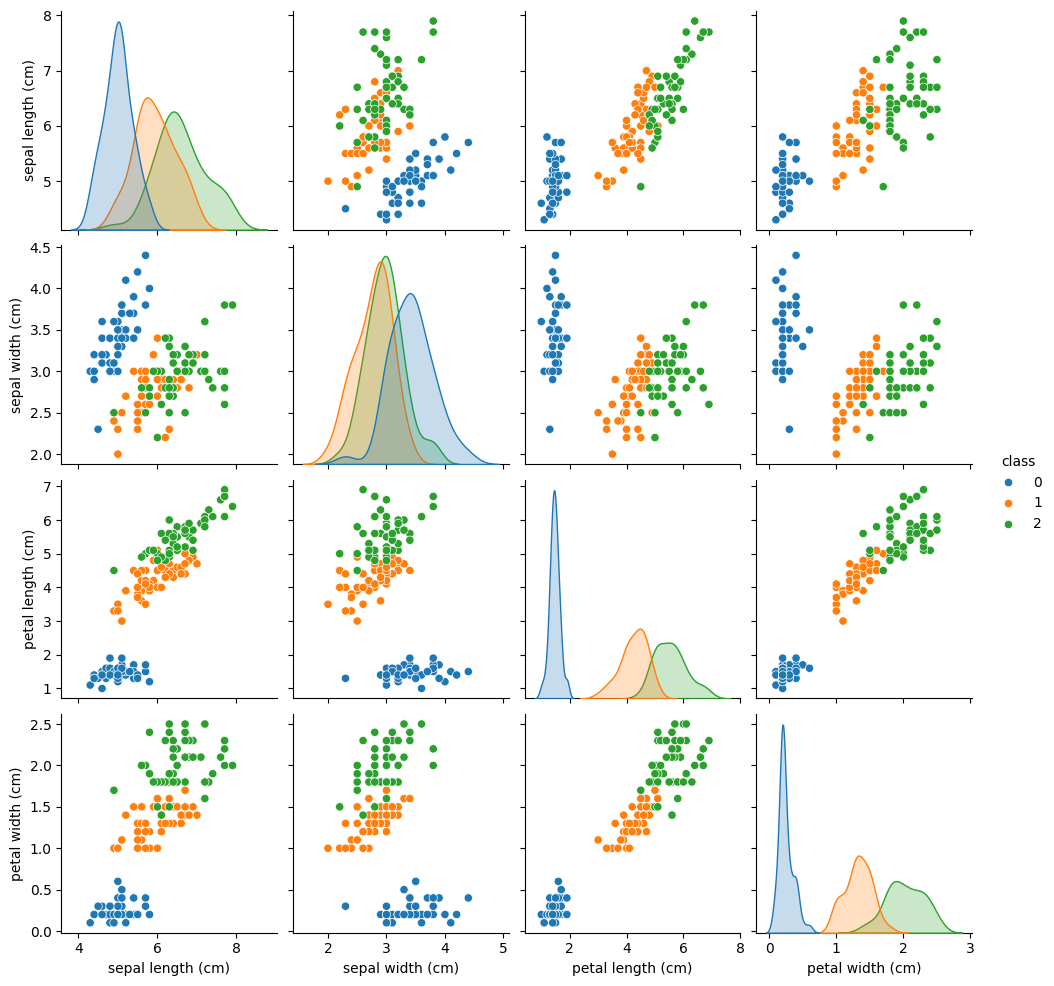

In [6]:
import pandas as pd
import seaborn as sns

df = pd.DataFrame(iris_data.data, columns=iris_data.feature_names)
df["class"] = pd.Series(iris_data.target)

sns.pairplot(df, hue="class", palette="tab10")

In [7]:
from sklearn.model_selection import train_test_split
from qiskit_machine_learning.utils import algorithm_globals

algorithm_globals.random_seed = 123
train_features, test_features, train_labels, test_labels = train_test_split(
    features, labels, train_size=0.8, random_state=algorithm_globals.random_seed
)

In [8]:
from sklearn.svm import SVC

svc = SVC()
_ = svc.fit(train_features, train_labels)  # suppress printing the return value

In [9]:
train_score_c4 = svc.score(train_features, train_labels)
test_score_c4 = svc.score(test_features, test_labels)

print(f"Classical SVC on the training dataset: {train_score_c4:.2f}")
print(f"Classical SVC on the test dataset:     {test_score_c4:.2f}")

Classical SVC on the training dataset: 0.99
Classical SVC on the test dataset:     0.97


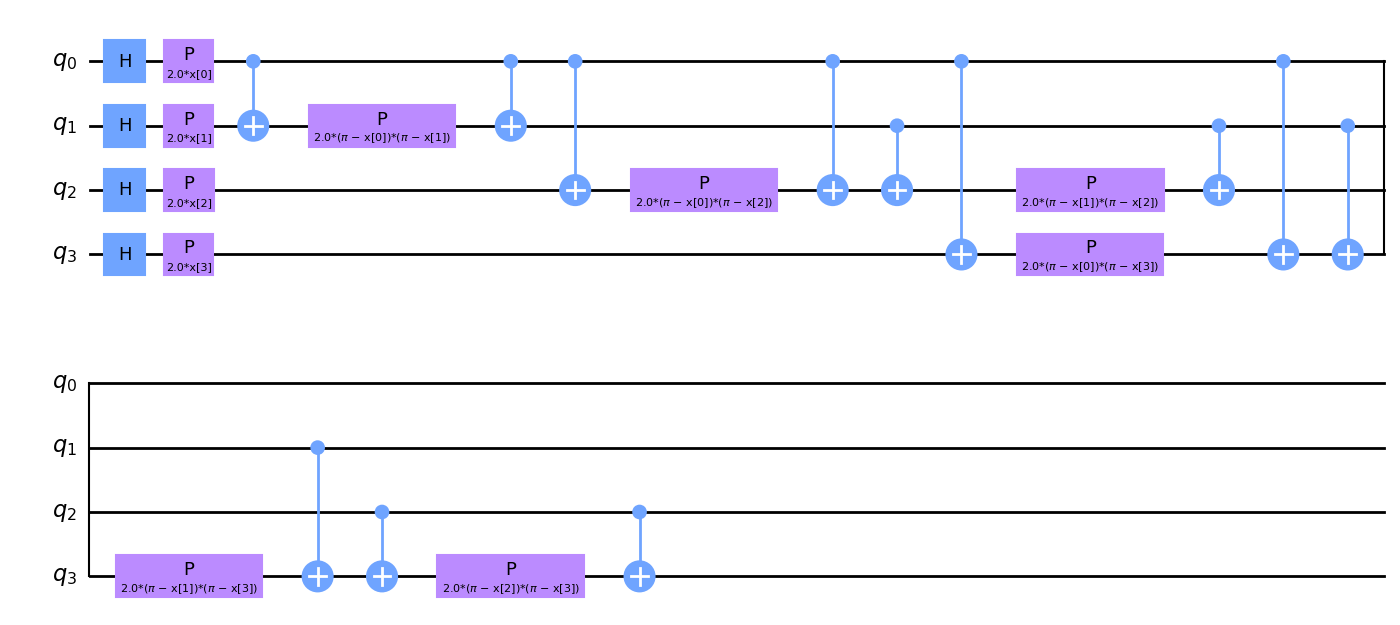

In [10]:
from qiskit.circuit.library import ZZFeatureMap

num_features = features.shape[1]

feature_map = ZZFeatureMap(feature_dimension=num_features, reps=1)
feature_map.decompose().draw(output="mpl", style="clifford", fold=20)

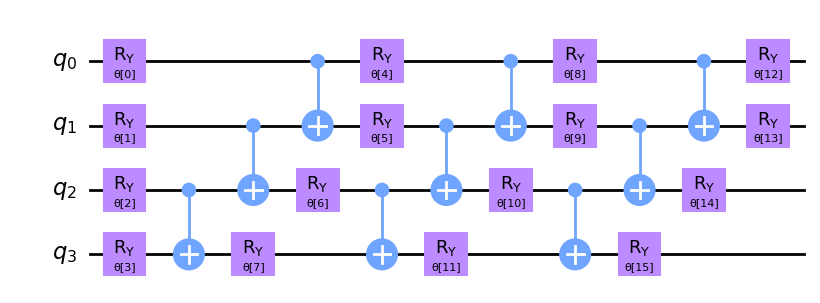

In [11]:
from qiskit.circuit.library import RealAmplitudes

ansatz = RealAmplitudes(num_qubits=num_features, reps=3)
ansatz.decompose().draw(output="mpl", style="clifford", fold=20)

In [12]:
from qiskit_machine_learning.optimizers import COBYLA, SPSA

optimizer = COBYLA(maxiter=100)

In [13]:
#from qiskit.primitives import Sampler
from quantumrings.toolkit.qiskit import QrSamplerV1 as Sampler

sampler = Sampler()

In [14]:
from matplotlib import pyplot as plt
from IPython.display import clear_output

objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)


def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

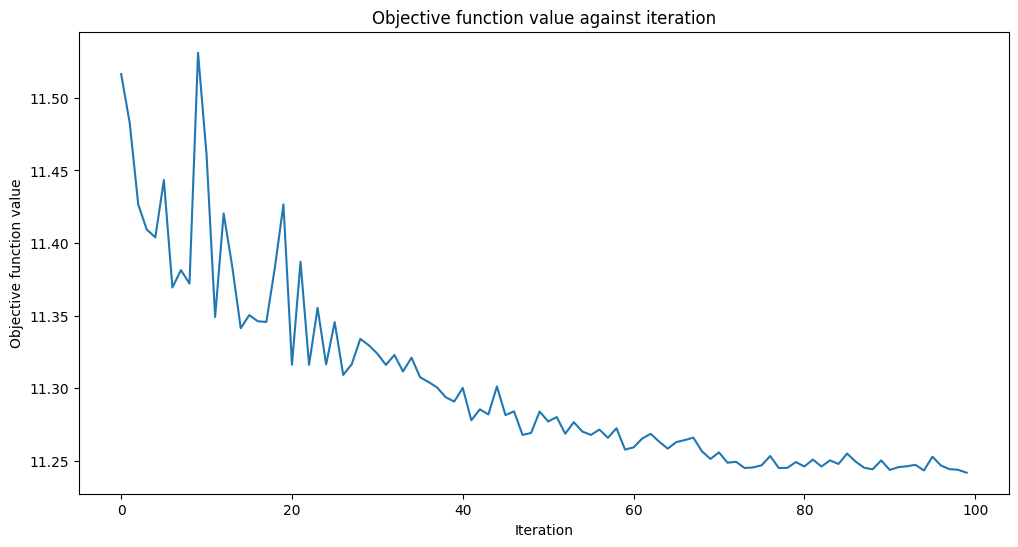

Training time: 803 seconds


In [15]:
import time
from qiskit_machine_learning.algorithms.classifiers import VQC

vqc = VQC(
    sampler=sampler,
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=optimizer,
    callback=callback_graph,
)

# clear objective value history
objective_func_vals = []

start = time.time()
vqc.fit(train_features, train_labels)
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")

In [16]:
train_score_q4 = vqc.score(train_features, train_labels)
test_score_q4 = vqc.score(test_features, test_labels)

print(f"Quantum VQC on the training dataset: {train_score_q4:.2f}")
print(f"Quantum VQC on the test dataset:     {test_score_q4:.2f}")

Quantum VQC on the training dataset: 0.63
Quantum VQC on the test dataset:     0.53


<Axes: >

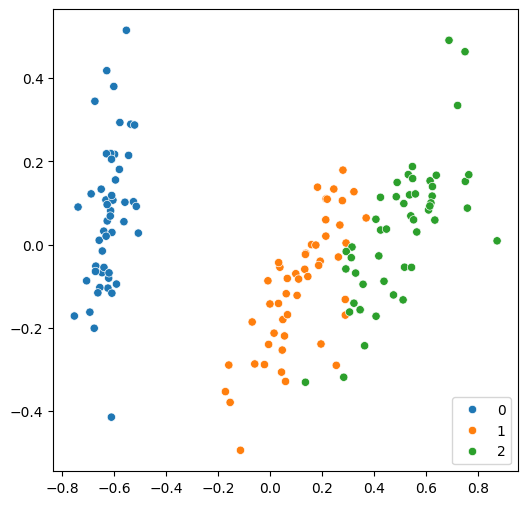

In [17]:
from sklearn.decomposition import PCA

features = PCA(n_components=2).fit_transform(features)

plt.rcParams["figure.figsize"] = (6, 6)
sns.scatterplot(x=features[:, 0], y=features[:, 1], hue=labels, palette="tab10")

In [18]:
train_features, test_features, train_labels, test_labels = train_test_split(
    features, labels, train_size=0.8, random_state=algorithm_globals.random_seed
)

svc.fit(train_features, train_labels)

train_score_c2 = svc.score(train_features, train_labels)
test_score_c2 = svc.score(test_features, test_labels)

print(f"Classical SVC on the training dataset: {train_score_c2:.2f}")
print(f"Classical SVC on the test dataset:     {test_score_c2:.2f}")

Classical SVC on the training dataset: 0.97
Classical SVC on the test dataset:     0.90


In [19]:
num_features = features.shape[1]

feature_map = ZZFeatureMap(feature_dimension=num_features, reps=1)
ansatz = RealAmplitudes(num_qubits=num_features, reps=3)

In [20]:
optimizer = COBYLA(maxiter=40)

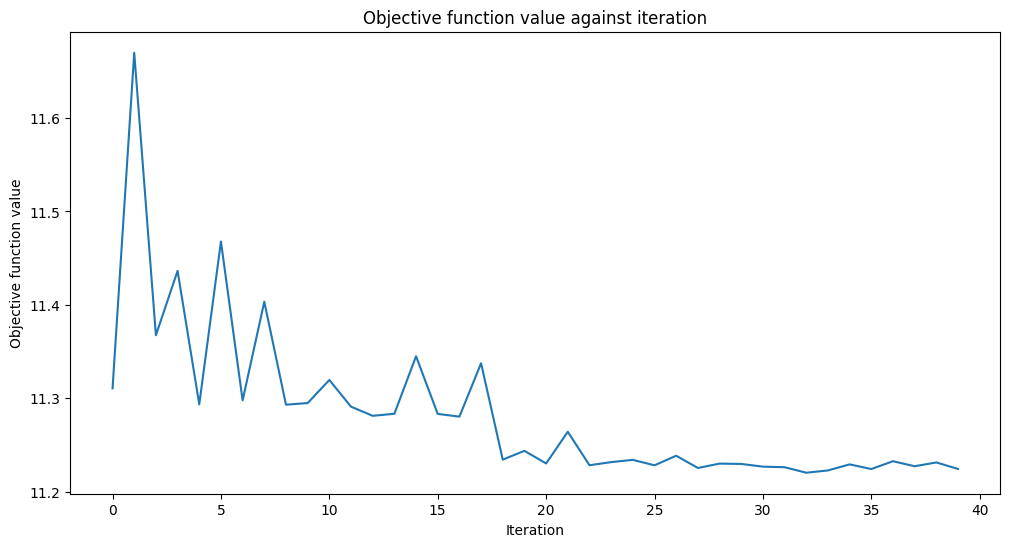

Training time: 138 seconds


In [21]:
vqc = VQC(
    sampler=sampler,
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=optimizer,
    callback=callback_graph,
)

# clear objective value history
objective_func_vals = []

# make the objective function plot look nicer.
plt.rcParams["figure.figsize"] = (12, 6)


start = time.time()
vqc.fit(train_features, train_labels)
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")

In [22]:
train_score_q2_ra = vqc.score(train_features, train_labels)
test_score_q2_ra = vqc.score(test_features, test_labels)

print(f"Quantum VQC on the training dataset using RealAmplitudes: {train_score_q2_ra:.2f}")
print(f"Quantum VQC on the test dataset using RealAmplitudes:     {test_score_q2_ra:.2f}")

Quantum VQC on the training dataset using RealAmplitudes: 0.53
Quantum VQC on the test dataset using RealAmplitudes:     0.43


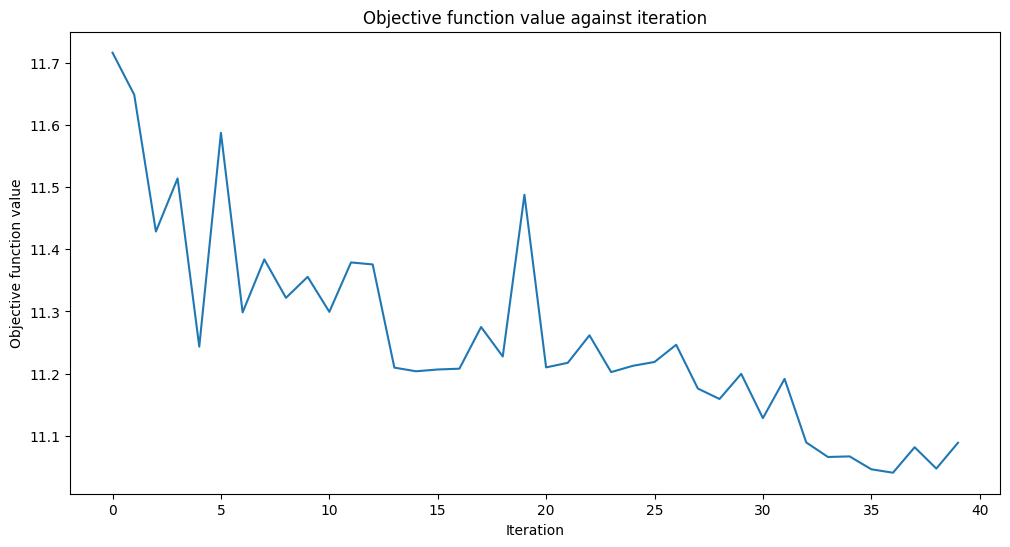

Training time: 146 seconds


In [23]:
from qiskit.circuit.library import EfficientSU2

ansatz = EfficientSU2(num_qubits=num_features, reps=3)
optimizer = COBYLA(maxiter=40)

vqc = VQC(
    sampler=sampler,
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=optimizer,
    callback=callback_graph,
)

# clear objective value history
objective_func_vals = []

start = time.time()
vqc.fit(train_features, train_labels)
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")

In [24]:
train_score_q2_eff = vqc.score(train_features, train_labels)
test_score_q2_eff = vqc.score(test_features, test_labels)

print(f"Quantum VQC on the training dataset using EfficientSU2: {train_score_q2_eff:.2f}")
print(f"Quantum VQC on the test dataset using EfficientSU2:     {test_score_q2_eff:.2f}")

Quantum VQC on the training dataset using EfficientSU2: 0.63
Quantum VQC on the test dataset using EfficientSU2:     0.63


In [25]:
print(f"Model                           | Test Score | Train Score")
print(f"SVC, 4 features                 | {train_score_c4:10.2f} | {test_score_c4:10.2f}")
print(f"VQC, 4 features, RealAmplitudes | {train_score_q4:10.2f} | {test_score_q4:10.2f}")
print(f"----------------------------------------------------------")
print(f"SVC, 2 features                 | {train_score_c2:10.2f} | {test_score_c2:10.2f}")
print(f"VQC, 2 features, RealAmplitudes | {train_score_q2_ra:10.2f} | {test_score_q2_ra:10.2f}")
print(f"VQC, 2 features, EfficientSU2   | {train_score_q2_eff:10.2f} | {test_score_q2_eff:10.2f}")

Model                           | Test Score | Train Score
SVC, 4 features                 |       0.99 |       0.97
VQC, 4 features, RealAmplitudes |       0.63 |       0.53
----------------------------------------------------------
SVC, 2 features                 |       0.97 |       0.90
VQC, 2 features, RealAmplitudes |       0.53 |       0.43
VQC, 2 features, EfficientSU2   |       0.63 |       0.63
